# Training & Comparison: ResNet50V2 vs MobileNetV2
Notebook ini akan melatih dua model Transfer Learning untuk membandingkan performanya pada dataset MangiferaNet.

In [1]:
# Import Library
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2, MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import shutil

2025-12-07 12:43:33.856261: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765111413.994811      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765111414.041343      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
# Setup Konfigurasi
DATA_RAW_DIR = '/kaggle/input/a-high-quality-mango-leaf-dataset'
DATA_SPLIT_DIR = '/kaggle/working/split_data'
OUTPUT_MODELS_DIR = '/kaggle/working/models'
OUTPUT_PLOTS_DIR = '/kaggle/working/plots'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 0.0001

print(f"TensorFlow Version: {tf.__version__}")
print("GPU Available:", len(tf.config.list_physical_devices('GPU')))

# Buat folder output otomatis
import os
os.makedirs(OUTPUT_MODELS_DIR, exist_ok=True)
os.makedirs(OUTPUT_PLOTS_DIR, exist_ok=True)

TensorFlow Version: 2.18.0
GPU Available: 2


## 1. Data Splitting (Train 70% / Val 15% / Test 15%)

In [3]:
def split_data(source, dest, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    if os.path.exists(dest):
        shutil.rmtree(dest) # Hapus folder lama jika ada
        
    classes = os.listdir(source)
    for c in classes:
        class_dir = os.path.join(source, c)
        if not os.path.isdir(class_dir): continue
        
        files = os.listdir(class_dir)
        # Split 1: Pisahkan Train dan (Val+Test)
        train_files, rest_files = train_test_split(files, train_size=train_ratio, random_state=42)
        # Split 2: Pisahkan Val dan Test
        val_ratio_adj = val_ratio / (val_ratio + test_ratio)
        val_files, test_files = train_test_split(rest_files, train_size=val_ratio_adj, random_state=42)
        
        # Helper copy
        for subset, file_list in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
            subset_dir = os.path.join(dest, subset, c)
            os.makedirs(subset_dir, exist_ok=True)
            for f in file_list:
                shutil.copy(os.path.join(class_dir, f), os.path.join(subset_dir, f))
                
    print(f"Data berhasil di-split ke: {dest}")

# Jalankan Splitting
split_data(DATA_RAW_DIR, DATA_SPLIT_DIR)

TRAIN_DIR = os.path.join(DATA_SPLIT_DIR, 'train')
VAL_DIR = os.path.join(DATA_SPLIT_DIR, 'val')
TEST_DIR = os.path.join(DATA_SPLIT_DIR, 'test')

Data berhasil di-split ke: /kaggle/working/split_data


## 2. Data Generators & Augmentation

In [4]:
# Augmentasi hanya untuk Training
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalisasi pixel 0-1
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validasi & Test hanya Rescale
val_test_datagen = ImageDataGenerator(rescale=1./255)

print("Loading Data...")
train_gen = train_datagen.flow_from_directory(TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
val_gen = val_test_datagen.flow_from_directory(VAL_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
test_gen = val_test_datagen.flow_from_directory(TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

CLASS_NAMES = list(train_gen.class_indices.keys())
NUM_CLASSES = len(CLASS_NAMES)
print(f"Kelas: {CLASS_NAMES}")

Loading Data...
Found 3495 images belonging to 5 classes.
Found 749 images belonging to 5 classes.
Found 749 images belonging to 5 classes.
Kelas: ['Anthracnose', 'Golmichi', 'Healthy', 'Powdery Mildew', 'Turning brown']


## 3. Membangun Fungsi Model Builder

In [5]:
def build_model(model_type='ResNet50V2'):
    if model_type == 'ResNet50V2':
        base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    elif model_type == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    
    # Freeze base model
    base_model.trainable = False
    
    # Custom Head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    if model_type == 'MobileNetV2':
        x = Dense(128, activation='relu')(x) 
    else:
        x = Dense(256, activation='relu')(x)
    
    x = BatchNormalization()(x) # Membantu stabilitas training
    x = Dropout(0.5)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=outputs, name=model_type)
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

## 4. Training Model 1: ResNet50V2

In [6]:
print("\nTRAINING MODEL 1: ResNet50V2")
model_resnet = build_model('ResNet50V2')
model_resnet.summary()

# Callbacks
checkpoint_resnet = ModelCheckpoint(os.path.join(OUTPUT_MODELS_DIR, 'best_resnet.h5'), monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_resnet = model_resnet.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=[checkpoint_resnet, early_stop]
)


TRAINING MODEL 1: ResNet50V2


I0000 00:00:1765111649.638351      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765111649.638951      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "ResNet50V2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 24,091,653 (91.90 MB)

 Trainable params: 526,341 (2.01 MB)

 Non-trainable params: 23,565,312 (89.89 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1765111669.813528      84 service.cc:148] XLA service 0x7d4660004280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765111669.815153      84 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765111669.815165      84 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765111671.299612      84 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/110 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.2109 - loss: 2.5080  

I0000 00:00:1765111677.848178      84 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4553 - loss: 1.6258
Epoch 1: val_accuracy improved from -inf to 0.80774, saving model to /kaggle/working/models/best_resnet.h5


110/110 ━━━━━━━━━━━━━━━━━━━━ 409s 4s/step - accuracy: 0.4565 - loss: 1.6224 - val_accuracy: 0.8077 - val_loss: 0.5341
Epoch 2/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7413 - loss: 0.7622
Epoch 2: val_accuracy improved from 0.80774 to 0.85314, saving model to /kaggle/working/models/best_resnet.h5


110/110 ━━━━━━━━━━━━━━━━━━━━ 359s 3s/step - accuracy: 0.7415 - loss: 0.7616 - val_accuracy: 0.8531 - val_loss: 0.4258
Epoch 3/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7922 - loss: 0.5813
Epoch 3: val_accuracy improved from 0.85314 to 0.88919, saving model to /kaggle/working/models/best_resnet.h5


110/110 ━━━━━━━━━━━━━━━━━━━━ 367s 3s/step - accuracy: 0.7922 - loss: 0.5812 - val_accuracy: 0.8892 - val_loss: 0.3327
Epoch 4/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8289 - loss: 0.5151
Epoch 4: val_accuracy did not improve from 0.88919
110/110 ━━━━━━━━━━━━━━━━━━━━ 351s 3s/step - accuracy: 0.8289 - loss: 0.5150 - val_accuracy: 0.8798 - val_loss: 0.3398
Epoch 5/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8364 - loss: 0.4859
Epoch 5: val_accuracy improved from 0.88919 to 0.90254, saving model to /kaggle/working/models/best_resnet.h5


110/110 ━━━━━━━━━━━━━━━━━━━━ 351s 3s/step - accuracy: 0.8364 - loss: 0.4857 - val_accuracy: 0.9025 - val_loss: 0.2944
Epoch 6/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8547 - loss: 0.4189
Epoch 6: val_accuracy did not improve from 0.90254
110/110 ━━━━━━━━━━━━━━━━━━━━ 347s 3s/step - accuracy: 0.8547 - loss: 0.4189 - val_accuracy: 0.8972 - val_loss: 0.2789
Epoch 7/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8599 - loss: 0.4021
Epoch 7: val_accuracy improved from 0.90254 to 0.90921, saving model to /kaggle/working/models/best_resnet.h5


110/110 ━━━━━━━━━━━━━━━━━━━━ 351s 3s/step - accuracy: 0.8599 - loss: 0.4021 - val_accuracy: 0.9092 - val_loss: 0.2805
Epoch 8/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8684 - loss: 0.3775
Epoch 8: val_accuracy improved from 0.90921 to 0.91055, saving model to /kaggle/working/models/best_resnet.h5


110/110 ━━━━━━━━━━━━━━━━━━━━ 391s 4s/step - accuracy: 0.8684 - loss: 0.3773 - val_accuracy: 0.9105 - val_loss: 0.2714
Epoch 9/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8740 - loss: 0.3731
Epoch 9: val_accuracy did not improve from 0.91055
110/110 ━━━━━━━━━━━━━━━━━━━━ 380s 3s/step - accuracy: 0.8740 - loss: 0.3731 - val_accuracy: 0.9079 - val_loss: 0.2716
Epoch 10/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8850 - loss: 0.3224
Epoch 10: val_accuracy improved from 0.91055 to 0.92657, saving model to /kaggle/working/models/best_resnet.h5


110/110 ━━━━━━━━━━━━━━━━━━━━ 353s 3s/step - accuracy: 0.8850 - loss: 0.3226 - val_accuracy: 0.9266 - val_loss: 0.2498
Epoch 11/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8759 - loss: 0.3296
Epoch 11: val_accuracy did not improve from 0.92657
110/110 ━━━━━━━━━━━━━━━━━━━━ 377s 3s/step - accuracy: 0.8759 - loss: 0.3295 - val_accuracy: 0.9199 - val_loss: 0.2613
Epoch 12/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8826 - loss: 0.3435
Epoch 12: val_accuracy did not improve from 0.92657
110/110 ━━━━━━━━━━━━━━━━━━━━ 359s 3s/step - accuracy: 0.8827 - loss: 0.3433 - val_accuracy: 0.9212 - val_loss: 0.2497
Epoch 13/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9030 - loss: 0.2802
Epoch 13: val_accuracy did not improve from 0.92657
110/110 ━━━━━━━━━━━━━━━━━━━━ 350s 3s/step - accuracy: 0.9030 - loss: 0.2802 - val_accuracy: 0.9119 - val_loss: 0.2552
Epoch 14/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8940 - loss: 0.3218
Epoch 14: val_accuracy did n

## 5. Training Model 2: MobileNetV2

In [7]:
print("\nTRAINING MODEL 2: MobileNetV2")
model_mobnet = build_model('MobileNetV2')
model_mobnet.summary()

# Callbacks
checkpoint_mobnet = ModelCheckpoint(os.path.join(OUTPUT_MODELS_DIR, 'best_mobnet.h5'), monitor='val_accuracy', save_best_only=True, verbose=1)

history_mobnet = model_mobnet.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=[checkpoint_mobnet, early_stop]
)


TRAINING MODEL 2: MobileNetV2
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "MobileNetV2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,423,109 (9.24 MB)

 Trainable params: 164,869 (644.02 KB)

 Non-trainable params: 2,258,240 (8.61 MB)

Epoch 1/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3696 - loss: 1.9376
Epoch 1: val_accuracy improved from -inf to 0.77704, saving model to /kaggle/working/models/best_mobnet.h5


110/110 ━━━━━━━━━━━━━━━━━━━━ 374s 3s/step - accuracy: 0.3708 - loss: 1.9334 - val_accuracy: 0.7770 - val_loss: 0.6752
Epoch 2/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6927 - loss: 0.8939
Epoch 2: val_accuracy improved from 0.77704 to 0.84246, saving model to /kaggle/working/models/best_mobnet.h5


110/110 ━━━━━━━━━━━━━━━━━━━━ 351s 3s/step - accuracy: 0.6930 - loss: 0.8930 - val_accuracy: 0.8425 - val_loss: 0.4466
Epoch 3/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7934 - loss: 0.6033
Epoch 3: val_accuracy improved from 0.84246 to 0.86649, saving model to /kaggle/working/models/best_mobnet.h5


110/110 ━━━━━━━━━━━━━━━━━━━━ 370s 3s/step - accuracy: 0.7934 - loss: 0.6033 - val_accuracy: 0.8665 - val_loss: 0.3847
Epoch 4/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8135 - loss: 0.5414
Epoch 4: val_accuracy did not improve from 0.86649
110/110 ━━━━━━━━━━━━━━━━━━━━ 349s 3s/step - accuracy: 0.8136 - loss: 0.5412 - val_accuracy: 0.8611 - val_loss: 0.3931
Epoch 5/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8413 - loss: 0.4757
Epoch 5: val_accuracy improved from 0.86649 to 0.87984, saving model to /kaggle/working/models/best_mobnet.h5


110/110 ━━━━━━━━━━━━━━━━━━━━ 348s 3s/step - accuracy: 0.8412 - loss: 0.4758 - val_accuracy: 0.8798 - val_loss: 0.3297
Epoch 6/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8502 - loss: 0.4537
Epoch 6: val_accuracy improved from 0.87984 to 0.89186, saving model to /kaggle/working/models/best_mobnet.h5


110/110 ━━━━━━━━━━━━━━━━━━━━ 352s 3s/step - accuracy: 0.8502 - loss: 0.4534 - val_accuracy: 0.8919 - val_loss: 0.3337
Epoch 7/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8729 - loss: 0.3822
Epoch 7: val_accuracy improved from 0.89186 to 0.89853, saving model to /kaggle/working/models/best_mobnet.h5


110/110 ━━━━━━━━━━━━━━━━━━━━ 366s 3s/step - accuracy: 0.8729 - loss: 0.3823 - val_accuracy: 0.8985 - val_loss: 0.3101
Epoch 8/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8684 - loss: 0.3941
Epoch 8: val_accuracy improved from 0.89853 to 0.90921, saving model to /kaggle/working/models/best_mobnet.h5


110/110 ━━━━━━━━━━━━━━━━━━━━ 362s 3s/step - accuracy: 0.8685 - loss: 0.3938 - val_accuracy: 0.9092 - val_loss: 0.2860
Epoch 9/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8764 - loss: 0.3651
Epoch 9: val_accuracy did not improve from 0.90921
110/110 ━━━━━━━━━━━━━━━━━━━━ 350s 3s/step - accuracy: 0.8764 - loss: 0.3650 - val_accuracy: 0.9039 - val_loss: 0.2866
Epoch 10/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8938 - loss: 0.3221
Epoch 10: val_accuracy did not improve from 0.90921
110/110 ━━━━━━━━━━━━━━━━━━━━ 352s 3s/step - accuracy: 0.8937 - loss: 0.3222 - val_accuracy: 0.9092 - val_loss: 0.3035
Epoch 11/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8987 - loss: 0.3164
Epoch 11: val_accuracy did not improve from 0.90921
110/110 ━━━━━━━━━━━━━━━━━━━━ 351s 3s/step - accuracy: 0.8987 - loss: 0.3165 - val_accuracy: 0.9079 - val_loss: 0.3018
Epoch 12/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8930 - loss: 0.3097
Epoch 12: val_accuracy improve

110/110 ━━━━━━━━━━━━━━━━━━━━ 349s 3s/step - accuracy: 0.8930 - loss: 0.3097 - val_accuracy: 0.9132 - val_loss: 0.2925
Epoch 13/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8928 - loss: 0.3142
Epoch 13: val_accuracy improved from 0.91322 to 0.91856, saving model to /kaggle/working/models/best_mobnet.h5


110/110 ━━━━━━━━━━━━━━━━━━━━ 347s 3s/step - accuracy: 0.8928 - loss: 0.3140 - val_accuracy: 0.9186 - val_loss: 0.2674
Epoch 14/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8866 - loss: 0.3024
Epoch 14: val_accuracy did not improve from 0.91856
110/110 ━━━━━━━━━━━━━━━━━━━━ 350s 3s/step - accuracy: 0.8867 - loss: 0.3023 - val_accuracy: 0.9146 - val_loss: 0.2589
Epoch 15/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9068 - loss: 0.2764
Epoch 15: val_accuracy did not improve from 0.91856
110/110 ━━━━━━━━━━━━━━━━━━━━ 349s 3s/step - accuracy: 0.9067 - loss: 0.2765 - val_accuracy: 0.9065 - val_loss: 0.2695


## 6. Komparasi Hasil & Evaluasi

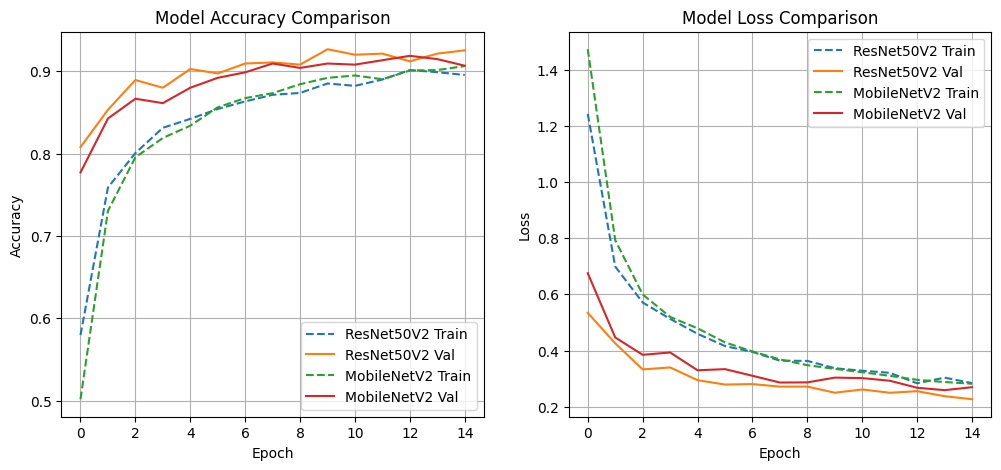

In [8]:
# 1. Plot Grafik Perbandingan
def plot_comparison(hist1, name1, hist2, name2):
    acc1 = hist1.history['accuracy']
    val_acc1 = hist1.history['val_accuracy']
    acc2 = hist2.history['accuracy']
    val_acc2 = hist2.history['val_accuracy']
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(acc1, label=f'{name1} Train', linestyle='--')
    plt.plot(val_acc1, label=f'{name1} Val')
    plt.plot(acc2, label=f'{name2} Train', linestyle='--')
    plt.plot(val_acc2, label=f'{name2} Val')
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    loss1 = hist1.history['loss']
    val_loss1 = hist1.history['val_loss']
    loss2 = hist2.history['loss']
    val_loss2 = hist2.history['val_loss']
    
    plt.subplot(1, 2, 2)
    plt.plot(loss1, label=f'{name1} Train', linestyle='--')
    plt.plot(val_loss1, label=f'{name1} Val')
    plt.plot(loss2, label=f'{name2} Train', linestyle='--')
    plt.plot(val_loss2, label=f'{name2} Val')
    plt.title('Model Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.savefig(os.path.join(OUTPUT_PLOTS_DIR, 'model_comparison.png')) # Simpan plot
    plt.show()

plot_comparison(history_resnet, 'ResNet50V2', history_mobnet, 'MobileNetV2')


--- Evaluasi ResNet50V2 pada Test Set ---
24/24 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.8781 - loss: 0.3326
Accuracy: 91.99%
24/24 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step
                precision    recall  f1-score   support

   Anthracnose       0.89      0.84      0.86       149
      Golmichi       0.88      0.85      0.86       150
       Healthy       0.90      0.99      0.95       150
Powdery Mildew       0.98      0.95      0.97       150
 Turning brown       0.95      0.97      0.96       150

      accuracy                           0.92       749
     macro avg       0.92      0.92      0.92       749
  weighted avg       0.92      0.92      0.92       749



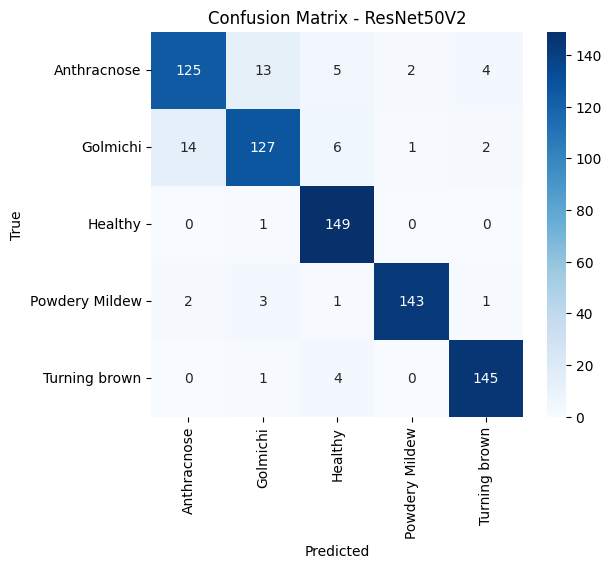


--- Evaluasi MobileNetV2 pada Test Set ---
24/24 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.8522 - loss: 0.3855
Accuracy: 90.25%
24/24 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step
                precision    recall  f1-score   support

   Anthracnose       0.93      0.76      0.83       149
      Golmichi       0.77      0.92      0.84       150
       Healthy       0.92      0.97      0.94       150
Powdery Mildew       0.98      0.93      0.96       150
 Turning brown       0.96      0.93      0.95       150

      accuracy                           0.90       749
     macro avg       0.91      0.90      0.90       749
  weighted avg       0.91      0.90      0.90       749



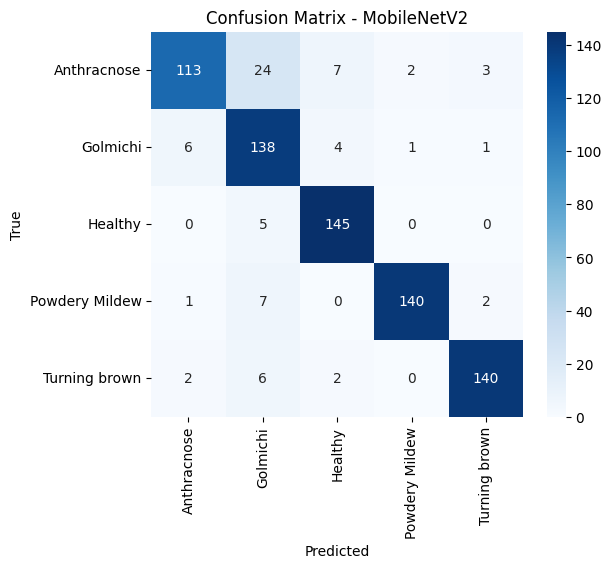

In [9]:
# 2. Evaluasi pada Test Set
def evaluate_model(model, generator, name):
    print(f"\n--- Evaluasi {name} pada Test Set ---")
    loss, acc = model.evaluate(generator)
    print(f"Accuracy: {acc*100:.2f}%")
    
    generator.reset()
    y_pred = np.argmax(model.predict(generator), axis=1)
    y_true = generator.classes
    
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plot_filename = os.path.join(OUTPUT_PLOTS_DIR, f'cm_{name}.png')
    plt.savefig(plot_filename)
    plt.show()
    return acc

acc_resnet = evaluate_model(model_resnet, test_gen, 'ResNet50V2')
acc_mobnet = evaluate_model(model_mobnet, test_gen, 'MobileNetV2')

In [10]:
# 3. Kesimpulan Akhir
print("\n=== KESIMPULAN AKHIR ===")
print(f"Akurasi ResNet50V2: {acc_resnet*100:.2f}%")
print(f"Akurasi MobileNetV2: {acc_mobnet*100:.2f}%")

if acc_resnet > acc_mobnet:
    best_model_name = "best_resnet.h5"
    print("Pemenang: ResNet50V2")
else:
    best_model_name = "best_mobnet.h5"
    print("Pemenang: MobileNetV2")


=== KESIMPULAN AKHIR ===
Akurasi ResNet50V2: 91.99%
Akurasi MobileNetV2: 90.25%
Pemenang: ResNet50V2
